# Análise do Portfolio de Fundos

### Inicializações

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime,timedelta
import math
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style("whitegrid")


In [2]:
#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')
exchange_rates.head()

,USD2EUR
Date,
2024-05-03,0.92868
2024-05-02,0.93190
2024-05-01,0.93315
2024-04-30,0.93740
2024-04-29,0.93304


In [3]:
#Get the Portofolio
portfolio_csv = 'portofolio.csv'
df_portofolio = pd.read_csv(portfolio_csv ,sep=';').set_index('Code')
code2name_dict = {x[0]:x[1] for x in df_portofolio.itertuples()}
df_portofolio.sort_values(by="Nome", axis=0)

,Nome,Moeda,Quantidade
Code,,,
LU1124235240,Aberdeen Diversified Income,EUR,903.760
LU0319687124,Amundi Volatility World,USD,114.554
LU0823433858,BNP Paribas Funds Turkey,EUR,33.783
IE00B432GG85,BNY Mell Glb Dyn Bond A,EUR,3609.770
LU1508158513,BlackRock Asia Pacific,EUR,171.550
LU2207571022,FF Absolute Return Global Hedged,EUR,1886.040
LU0788144201,Fidelity China RMB Bond,EUR,1639.470
LU1038809395,Flossbach Multiple Opportunit,EUR,47.684
LU0122614463,Franklin Dollar Short Term Money,USD,2293.606


In [4]:
#Get the historical quotes 

xls = 'historico_cotacoes.xlsx'
dict_df = pd.read_excel(xls,sheet_name=None)

# Parse the date and set it as index
for key in dict_df.keys():
    dict_df[key]['Date'] = dict_df[key].apply(lambda x: pd.to_datetime(x['Date']).date(), axis=1)
    dict_df[key].set_index('Date',drop=True, inplace=True)

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_all = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False)
df_all

,LU0122613903,LU0705071453,LU0235843108,LU0319687124,LU0122614463,LU0132636399,LU0252500524,LU1508158513,LU1799936197,IE00B432GG85,...,LU0788144201,LU1735753946,LU0140363267,LU0823433858,LU1124235240,LU1245572752,LU2207571022,IE00BLP5S353,LU1038809395,LU1308313201
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-03,NaN,NaN,146.88,NaN,NaN,NaN,109.24,140.12,NaN,1.35,...,13.33,NaN,25.03,NaN,9.48,9.44,10.02,1.57,170.09,NaN
2024-05-02,13.44,156.04,147.33,104.50,10.98,106.15,109.22,139.70,114.60,1.36,...,13.36,NaN,24.95,278.93,9.48,9.48,10.06,1.57,169.98,161.68
2024-05-01,13.42,NaN,147.31,NaN,10.97,NaN,NaN,NaN,NaN,1.36,...,13.36,NaN,24.74,NaN,NaN,NaN,10.05,1.57,NaN,NaN
2024-04-30,13.42,156.09,146.95,104.21,10.97,106.12,109.21,139.93,114.21,1.36,...,13.33,17.94,24.81,275.08,9.52,9.49,10.05,1.58,171.41,162.42
2024-04-29,13.53,155.82,146.99,103.70,10.97,106.09,109.20,139.64,114.73,1.36,...,13.35,17.87,25.05,275.01,9.49,9.49,10.04,1.58,171.51,162.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-02,28.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-01,28.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30,27.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#Create a DataFrame starting from the furthest Date where all Funds have a valid amount, and replace a NaN with the last value known
df = df_all.loc[:df_all.index.min()].bfill().dropna()

#Create a DataFrame with the daily growth
df_grow = df.apply(lambda x: x/x.shift(-1), axis=0)
df

,LU0122613903,LU0705071453,LU0235843108,LU0319687124,LU0122614463,LU0132636399,LU0252500524,LU1508158513,LU1799936197,IE00B432GG85,...,LU0788144201,LU1735753946,LU0140363267,LU0823433858,LU1124235240,LU1245572752,LU2207571022,IE00BLP5S353,LU1038809395,LU1308313201
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-03,13.44,156.04,146.88,104.50,10.98,106.15,109.24,140.12,114.60,1.35,...,13.33,17.94,25.03,278.93,9.48,9.44,10.02,1.57,170.09,161.68
2024-05-02,13.44,156.04,147.33,104.50,10.98,106.15,109.22,139.70,114.60,1.36,...,13.36,17.94,24.95,278.93,9.48,9.48,10.06,1.57,169.98,161.68
2024-05-01,13.42,156.09,147.31,104.21,10.97,106.12,109.21,139.93,114.21,1.36,...,13.36,17.94,24.74,275.08,9.52,9.49,10.05,1.57,171.41,162.42
2024-04-30,13.42,156.09,146.95,104.21,10.97,106.12,109.21,139.93,114.21,1.36,...,13.33,17.94,24.81,275.08,9.52,9.49,10.05,1.58,171.41,162.42
2024-04-29,13.53,155.82,146.99,103.70,10.97,106.09,109.20,139.64,114.73,1.36,...,13.35,17.87,25.05,275.01,9.49,9.49,10.04,1.58,171.51,162.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-08,8.92,139.19,150.62,106.74,10.54,101.19,105.94,118.27,108.72,1.30,...,13.29,20.19,21.91,164.54,9.22,9.96,9.68,1.40,157.42,145.62
2023-05-05,8.92,138.96,151.22,106.73,10.54,101.19,105.92,118.15,108.81,1.30,...,13.29,20.05,21.88,157.86,9.23,9.99,9.67,1.40,156.39,145.41
2023-05-04,8.92,138.73,151.99,107.14,10.53,101.18,105.91,118.14,108.88,1.29,...,13.29,20.13,21.50,159.65,9.21,9.99,9.72,1.41,155.79,143.55


In [6]:
# Calculate the Portofolio Std and Growth
df_portofolio['STD'] = df_grow.std(axis=0)
df_portofolio['Growth'] = df.apply(lambda x: x.iloc[0]/x.iloc[-1]-1)
df_portofolio['Racio'] = df_portofolio['Growth']/df_portofolio['STD']

In [7]:
# Get the Current Total Amount in EUR

last_date = min(df.index[0],exchange_rates.index[0])
# Get the exchange rate for the last date of the historical quotes
usd2eur = exchange_rates.loc[last_date].iloc[0]
# Get the last Quotes
quotes = df_all.bfill().iloc[0]

df_portofolio['Amount EUR'] = df_portofolio['Moeda'].apply(lambda x: usd2eur if x == 'USD' else 1) * quotes * df_portofolio['Quantidade']

sum(df_portofolio['Amount EUR'])

337431.61535762594

c:\MyPrograms\miniconda3\envs\fundos\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\MyPrograms\miniconda3\envs\fundos\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


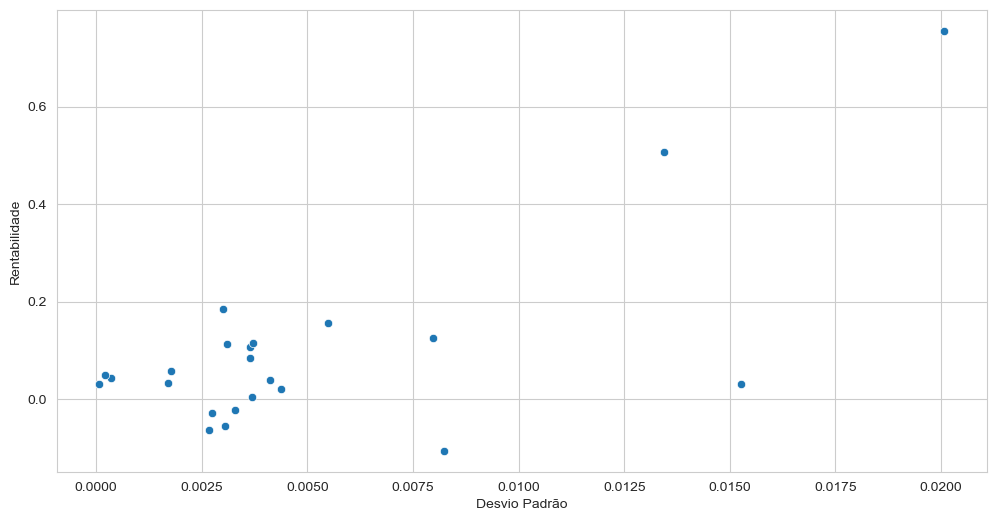

In [8]:
plt.figure(figsize=(12,6))
plt.xlabel('Desvio Padrão')
plt.ylabel('Rentabilidade')
p = sn.scatterplot(x=df_portofolio['STD'],y=df_portofolio['Growth'])

In [9]:
df_portofolio.sort_values(by=['Nome'],ascending=True)

,Nome,Moeda,Quantidade,STD,Growth,Racio,Amount EUR
Code,,,,,,,
LU1124235240,Aberdeen Diversified Income,EUR,903.760,0.004386,0.020452,4.663021,8567.644800
LU0319687124,Amundi Volatility World,USD,114.554,0.003282,-0.022634,-6.896947,11117.128911
LU0823433858,BNP Paribas Funds Turkey,EUR,33.783,0.020079,0.755381,37.620801,9423.092190
IE00B432GG85,BNY Mell Glb Dyn Bond A,EUR,3609.770,0.004109,0.038462,9.361013,4873.189500
LU1508158513,BlackRock Asia Pacific,EUR,171.550,0.003013,0.185348,61.522967,24037.586000
LU2207571022,FF Absolute Return Global Hedged,EUR,1886.040,0.001702,0.032990,19.377460,18898.120800
LU0788144201,Fidelity China RMB Bond,EUR,1639.470,0.003699,0.004521,1.222220,21854.135100
LU1038809395,Flossbach Multiple Opportunit,EUR,47.684,0.003651,0.085173,23.328824,8110.571560
LU0122614463,Franklin Dollar Short Term Money,USD,2293.606,0.000352,0.042735,121.356962,23387.685700


In [10]:
df_portofolio['Amount EUR'].sum()

337431.615357626

In [11]:
df_portofolio = df_portofolio[df_portofolio.index != "LU0122613903"]

<Figure size 1200x800 with 0 Axes>

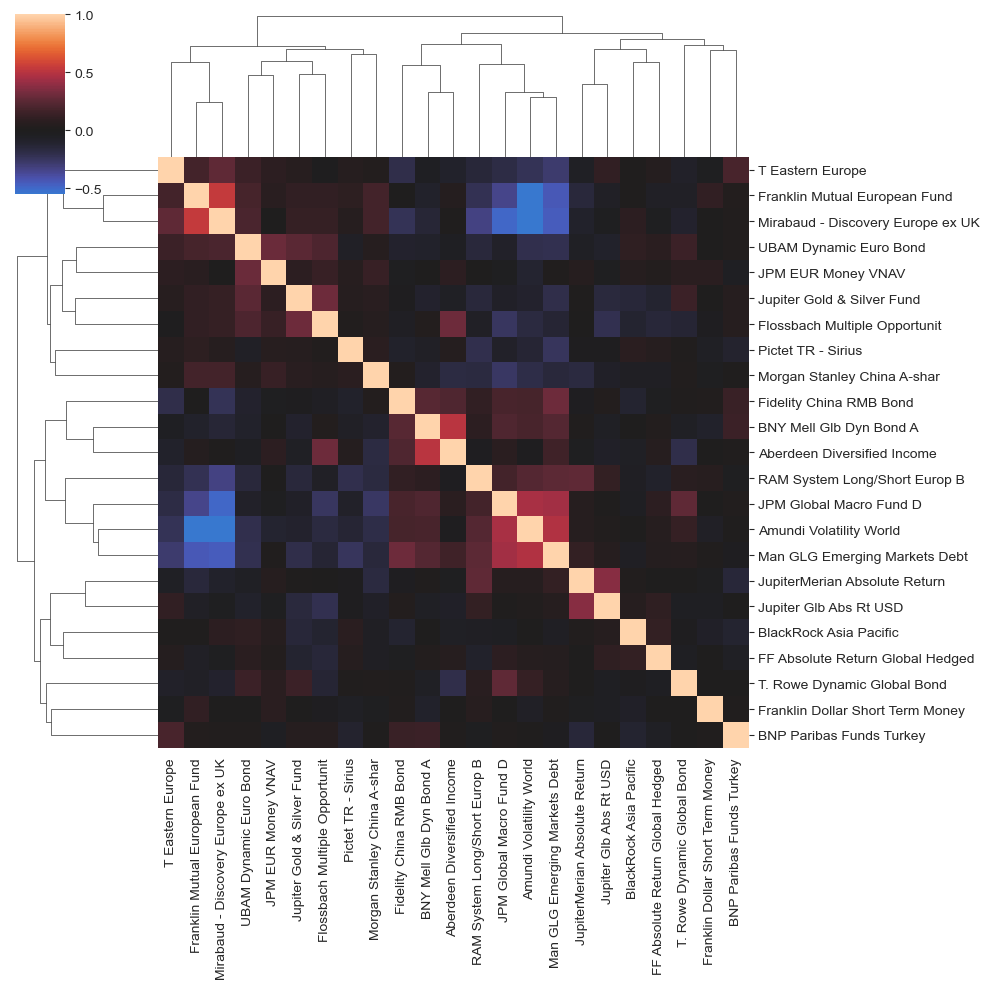

In [12]:
plt.figure(figsize=(12,8))
sn.clustermap(df_grow.rename(columns=code2name_dict).corr(),center=0)
#df_grow.corr()

In [13]:
##### Performance in the last days
df_portofolio_tmp = df_portofolio.copy()
start =66
finish = 0
print('Start Date:',df_all.index[start])
df_portofolio_tmp['Growth'] = df_all.bfill().ffill().apply(lambda x: x.iloc[finish]/x.iloc[start]-1)
df_portofolio_tmp['Racio'] = df_portofolio_tmp['Growth']/df_portofolio_tmp['STD']
# Save Portfoloio
# df_portofolio_tmp.sort_values(by=['Racio'],ascending=False).to_csv("portfolio_data.csv",sep=",")
# Show Portfolio
df_portofolio_tmp.sort_values(by=['Growth'],ascending=False)

Start Date: 2024-02-01


,Nome,Moeda,Quantidade,STD,Growth,Racio,Amount EUR
Code,,,,,,,
IE00BYVJR916,Jupiter Gold & Silver Fund,EUR,425.037,0.015256,0.256659,16.823631,4411.884060
LU0823433858,BNP Paribas Funds Turkey,EUR,33.783,0.020079,0.167413,8.337799,9423.092190
LU1735753946,Morgan Stanley China A-shar,USD,414.221,0.008243,0.082680,10.030468,6901.136924
LU0140363267,Franklin Mutual European Fund,EUR,693.672,0.005478,0.071949,13.133368,17362.610160
LU1308313201,Mirabaud - Discovery Europe ex UK,EUR,87.452,0.007986,0.071935,9.008008,14139.239360
LU1508158513,BlackRock Asia Pacific,EUR,171.550,0.003013,0.056154,18.639431,24037.586000
LU0705071453,RAM System Long/Short Europ B,EUR,83.587,0.003719,0.052475,14.110431,13042.915480
LU1799936197,Pictet TR - Sirius,USD,247.477,0.001763,0.028448,16.135378,26338.167365
LU1038809395,Flossbach Multiple Opportunit,EUR,47.684,0.003651,0.023775,6.511999,8110.571560


Start Date: 2024-02-01


<Axes: xlabel='Date'>

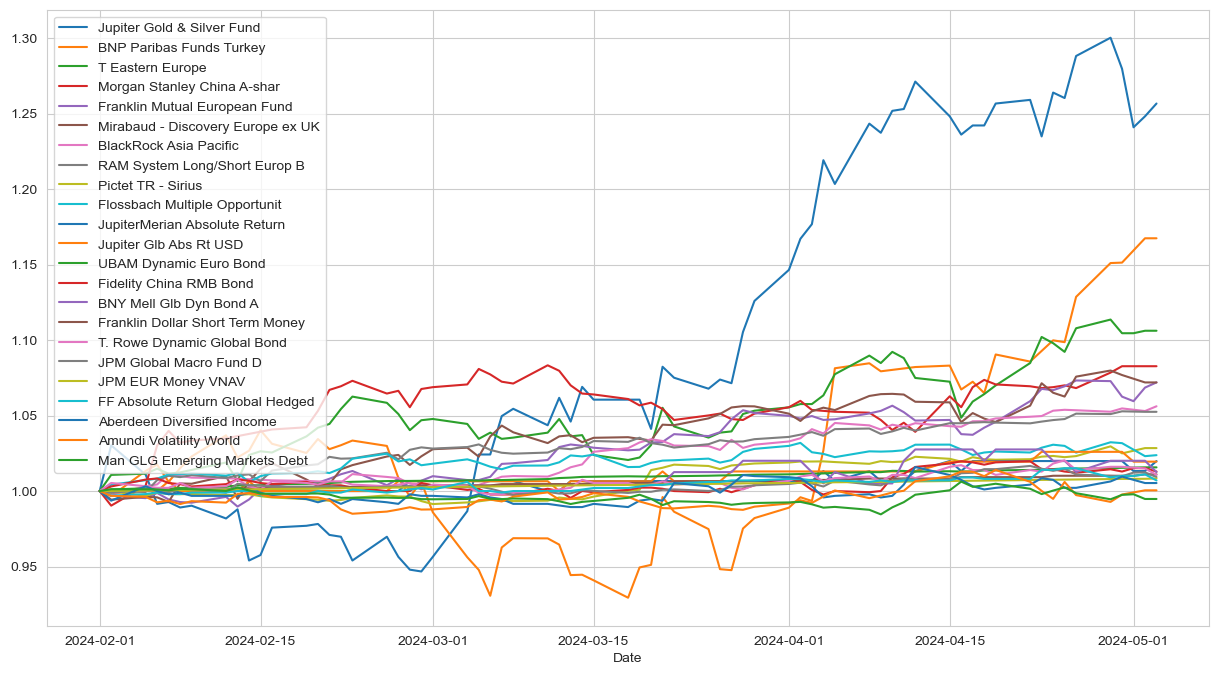

In [14]:
# Select Funds
fund_filter = df_all.columns
#fund_filter = []

print('Start Date:',df_all.index[start])
df_all_tmp = df_all.interpolate().bfill().ffill().apply(lambda x: x/x.iloc[start], axis=0)[fund_filter]
df_all_tmp = df_all_tmp.sort_values(by=df_all_tmp.index[finish],axis=1,ascending=False).rename(columns=code2name_dict)
ax = df_all_tmp.iloc[finish:start+1].plot(figsize=(15,8),grid=True)
ax.legend(loc='upper left')
ax

In [15]:
##### Performance in the last days
df_portofolio_tmp = df_portofolio.copy()
start =15
finish = 0
print('Start Date:',df_all.index[start])
df_portofolio_tmp['Growth'] = df_all.bfill().ffill().apply(lambda x: x.iloc[finish]/x.iloc[start]-1)
df_portofolio_tmp['Racio'] = df_portofolio_tmp['Growth']/df_portofolio_tmp['STD']
# Save Portfoloio
# df_portofolio_tmp.sort_values(by=['Nome'],ascending=True)
df_portofolio_tmp.sort_values(by=['Racio'],ascending=False) #.to_csv("portfolio_data.csv",sep=",")


Start Date: 2024-04-12


,Nome,Moeda,Quantidade,STD,Growth,Racio,Amount EUR
Code,,,,,,,
LU0252500524,JPM EUR Money VNAV,EUR,210.715,0.000067,0.001926,28.684245,23018.506600
LU0132636399,UBAM Dynamic Euro Bond,EUR,215.955,0.000218,0.002739,12.560178,22923.623250
LU0122614463,Franklin Dollar Short Term Money,USD,2293.606,0.000352,0.002740,7.780145,23387.685700
LU1735753946,Morgan Stanley China A-shar,USD,414.221,0.008243,0.041812,5.072505,6901.136924
LU0140363267,Franklin Mutual European Fund,EUR,693.672,0.005478,0.024141,4.406609,17362.610160
LU0823433858,BNP Paribas Funds Turkey,EUR,33.783,0.020079,0.081627,4.065337,9423.092190
LU1508158513,BlackRock Asia Pacific,EUR,171.550,0.003013,0.010748,3.567616,24037.586000
LU0705071453,RAM System Long/Short Europ B,EUR,83.587,0.003719,0.011933,3.208619,13042.915480
LU1799936197,Pictet TR - Sirius,USD,247.477,0.001763,0.005616,3.185294,26338.167365


Start Date: 2024-04-12


<Axes: xlabel='Date'>

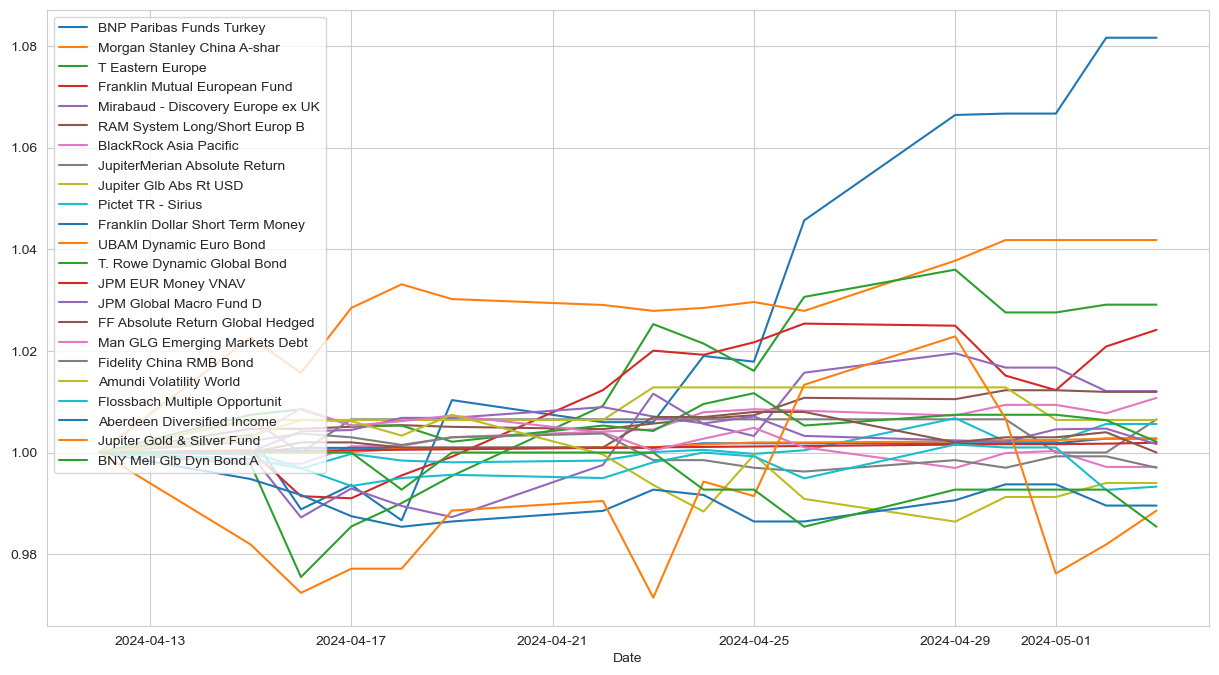

In [16]:

print('Start Date:',df_all.index[start])
df_all_tmp = df_all.bfill().apply(lambda x: x/x.iloc[start], axis=0)
df_all_tmp = df_all_tmp.sort_values(by=df_all_tmp.index[finish],axis=1,ascending=False).rename(columns=code2name_dict)
ax = df_all_tmp.iloc[finish:start+1].plot(figsize=(15,8),grid=True)
ax.legend(loc='upper left')
ax

In [17]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

if 'LU0122613903' in dict_df:
    del dict_df['LU0122613903']

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_all = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False)
df = df_all #.dropna()

# print(df.index)

mu = mean_historical_return(df.sort_index())
S = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
df_mu = pd.DataFrame(data = {'Name':df_portofolio['Nome'],'all':list(mu)}, index=list(mu.keys()))
df_w = pd.DataFrame(data = {'Name':df_portofolio['Nome'] ,'all':list(cleaned_weights.values())}, index=list(cleaned_weights.keys()))
df_pp = pd.DataFrame(data = {'all':list(ef.portfolio_performance())}, index=list(['anual return','volatility','sharpe ratio']))
mu_coef = {'all':0.3,90:0.3,5:0.15,10:0.15,30:0.10}
mu_w = mu_coef['all']*mu
for n in mu_coef.keys()-['all']:
    mu = mean_historical_return(df[:n].sort_index())
    
    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    if n == 60:
        mu_w += 0.30*mu
    else:
        mu_w += 0.175*mu
    df_mu[n] = list(mu)
    df_w[n] = list(cleaned_weights.values())
    df_pp[n] = list(ef.portfolio_performance())
    

ef = EfficientFrontier(mu_w, S)
weights = ef.max_sharpe()

df_w['Avg'] = list(ef.clean_weights().values())
df_w['Now'] = df_portofolio_tmp['Amount EUR']/df_portofolio_tmp['Amount EUR'].sum()
df_pp['Avg'] = list(ef.portfolio_performance())
df_mu['Avg'] = list(mu_w)
df_mu.sort_values(by="Avg",ascending=False)

c:\MyPrograms\miniconda3\envs\fundos\Lib\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = prices.pct_change().dropna(how="all")
c:\MyPrograms\miniconda3\envs\fundos\Lib\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = prices.pct_change().dropna(how="all")
c:\MyPrograms\miniconda3\envs\fundos\Lib\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warnin

,Name,all,10,5,90,30,Avg
LU0823433858,BNP Paribas Funds Turkey,0.721649,6.616748e+00,1.439185e+00,1.444203,3.791391e+00,2.542512
IE00BYVJR916,Jupiter Gold & Silver Fund,-0.014993,-5.247125e-02,-8.832751e-01,0.429213,3.117263e+00,0.452380
LU1508158513,BlackRock Asia Pacific,0.183415,2.025552e-01,2.413326e-01,0.300571,2.458427e-01,0.228327
LU0140363267,Franklin Mutual European Fund,0.134618,3.858375e-01,-4.907444e-02,0.229297,3.404919e-01,0.199032
LU0705071453,RAM System Long/Short Europ B,0.034899,2.256929e-01,9.295611e-02,0.350755,1.959242e-01,0.161902
LU1735753946,Morgan Stanley China A-shar,-0.092365,4.126813e-01,2.792836e-01,0.067651,3.041857e-01,0.158456
LU1308313201,Mirabaud - Discovery Europe ex UK,0.121763,4.988405e-01,-3.699749e-01,0.264258,2.154600e-01,0.143031
LU0319687124,Amundi Volatility World,-0.022368,-1.458441e-01,6.227987e-01,-0.002164,9.355523e-02,0.092750
IE00BLP5S460,JupiterMerian Absolute Return,0.109086,-3.108624e-15,-6.994405e-15,0.119098,1.202948e-01,0.074620
LU1799936197,Pictet TR - Sirius,0.051954,2.227095e-01,-6.893433e-02,0.070381,1.059129e-01,0.073348


In [18]:
df_mu.sort_values(by=5,ascending=False)

,Name,all,10,5,90,30,Avg
LU0823433858,BNP Paribas Funds Turkey,0.721649,6.616748e+00,1.439185e+00,1.444203,3.791391e+00,2.542512
LU0319687124,Amundi Volatility World,-0.022368,-1.458441e-01,6.227987e-01,-0.002164,9.355523e-02,0.092750
LU1735753946,Morgan Stanley China A-shar,-0.092365,4.126813e-01,2.792836e-01,0.067651,3.041857e-01,0.158456
LU1508158513,BlackRock Asia Pacific,0.183415,2.025552e-01,2.413326e-01,0.300571,2.458427e-01,0.228327
LU0705071453,RAM System Long/Short Europ B,0.034899,2.256929e-01,9.295611e-02,0.350755,1.959242e-01,0.161902
LU0122614463,Franklin Dollar Short Term Money,0.041042,5.237375e-02,5.908274e-02,0.042439,4.045774e-02,0.046325
LU0132636399,UBAM Dynamic Euro Bond,0.051496,4.866747e-02,3.626205e-02,0.058015,4.876174e-02,0.048997
LU0252500524,JPM EUR Money VNAV,0.029529,2.861065e-02,2.334093e-02,0.032582,3.156661e-02,0.029176
IE00BD3B6K23,Man GLG Emerging Markets Debt,-0.060685,-1.727743e-01,1.286616e-02,0.022454,1.780602e-02,-0.039144
IE00BLP5S460,JupiterMerian Absolute Return,0.109086,-3.108624e-15,-6.994405e-15,0.119098,1.202948e-01,0.074620


In [19]:
df_mu.sort_values(by="Avg",ascending=False).to_csv("mu.csv")

In [20]:
df_w.sort_values(by=['Avg',5,'all',10,30,90],ascending=False)

,Name,all,10,5,90,30,Avg,Now
LU1508158513,BlackRock Asia Pacific,0.16569,0.13139,0.14956,0.16983,0.15831,0.18142,0.071328
LU0132636399,UBAM Dynamic Euro Bond,0.20055,0.07839,0.10313,0.12356,0.05651,0.13164,0.068023
LU0122614463,Franklin Dollar Short Term Money,0.13990,0.11631,0.17457,0.07515,0.04981,0.12782,0.069400
LU1799936197,Pictet TR - Sirius,0.07617,0.30830,0.00000,0.08887,0.11442,0.12600,0.078155
LU0319687124,Amundi Volatility World,0.00000,0.00000,0.39264,0.01560,0.07068,0.10474,0.032989
IE00BLP5S460,JupiterMerian Absolute Return,0.07159,0.07884,0.00000,0.03463,0.04136,0.06806,0.012642
LU0140363267,Franklin Mutual European Fund,0.04432,0.04718,0.08220,0.04649,0.06249,0.06567,0.051521
LU0823433858,BNP Paribas Funds Turkey,0.02562,0.10801,0.02718,0.02681,0.05089,0.06005,0.027962
LU0705071453,RAM System Long/Short Europ B,0.00713,0.06420,0.00552,0.08438,0.04718,0.04929,0.038703
LU0252500524,JPM EUR Money VNAV,0.06080,0.02254,0.01430,0.04178,0.02653,0.04005,0.068304


In [21]:
df_pp

,all,10,5,90,30,Avg
anual return,0.100094,0.872716,0.344833,0.182314,0.552469,0.265867
volatility,0.012417,0.028908,0.019295,0.013101,0.020594,0.018406
sharpe ratio,6.450212,29.497733,16.834699,12.389658,25.855165,13.358092
